# Exercise 14: Trends in IN Snow

In this exercise, we will build on geospatial skills from last week to assemble a dataset of snow observations in Indiana from a global dataset of meteorological observations.  The aim will be to ask whether there are trends in snow in IN.  This exercise will involve automatically downloading data from an external source.

The source dataset is: https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

In [1]:
""" Import libraries. """
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm # for a progress bar; you'll need to install tqdm and ipywidgets
import scipy
import datetime as dt

In [2]:
""" Load the inventory file. """

# set the inventory file
inv_path = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"

# load the inventory file into a pandas dataframe
inv_df = pd.read_fwf(
    inv_path, 
    header=None,
    names=['Station_ID', 'latitude', 'longitude', 'element_type', 'begin[yr]', 'end[yr]'])

inv_df.head()

,Station_ID,latitude,longitude,element_type,begin[yr],end[yr]
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949


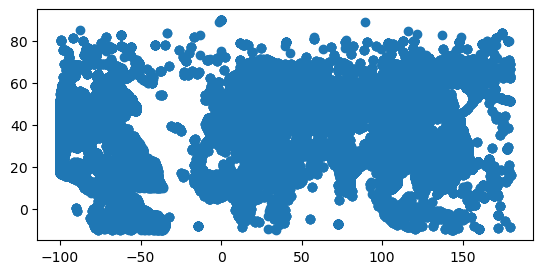

In [3]:
""" Convert the inventory dataframe to a geopandas dataframe. """
# convert the pandas dataframe into a geodataframe
inv_gdf = gpd.GeoDataFrame(
    inv_df,
    geometry=gpd.points_from_xy(
        inv_df.longitude,
        inv_df.latitude,
        ),
    crs="EPSG:4326", # this is the coordinate reference system for lat/lon
    )

# plot the dataframe
inv_gdf.plot();

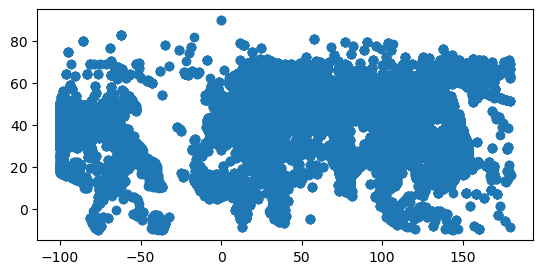

In [4]:
""" Find stations that have at least 50 years of data. """

# find stations that have at least 50 years of data
inv_50_gdf = inv_gdf[inv_gdf['end[yr]'] - inv_gdf['begin[yr]'] >= 50]

# plot the stations that have at least 50 years of SNOW data
inv_50_gdf.plot();

,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


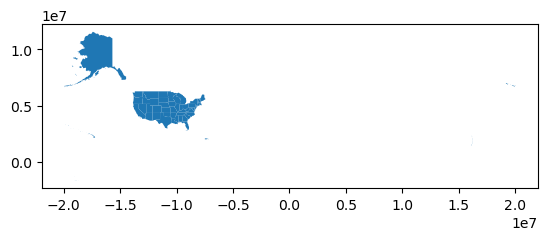

In [5]:
""" Load the state boundary shapefile. """

# set the path to the shapefile
state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the state boundary shapefile
state_boundary_gdf = gpd.read_file(state_shapefile_path)

# plot the state boundary shapefile
state_boundary_gdf.plot();

state_boundary_gdf.head()

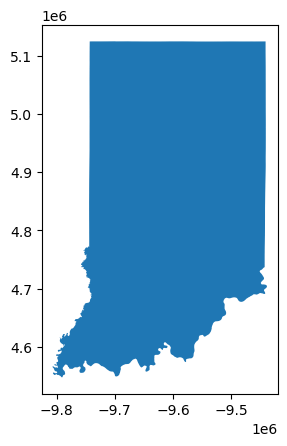

In [6]:
""" Extract the IN row. """
# extract the IN row
IN_boundary_gdf = state_boundary_gdf[state_boundary_gdf['STUSPS'] == 'IN']

# plot the IN boundary
IN_boundary_gdf.plot();

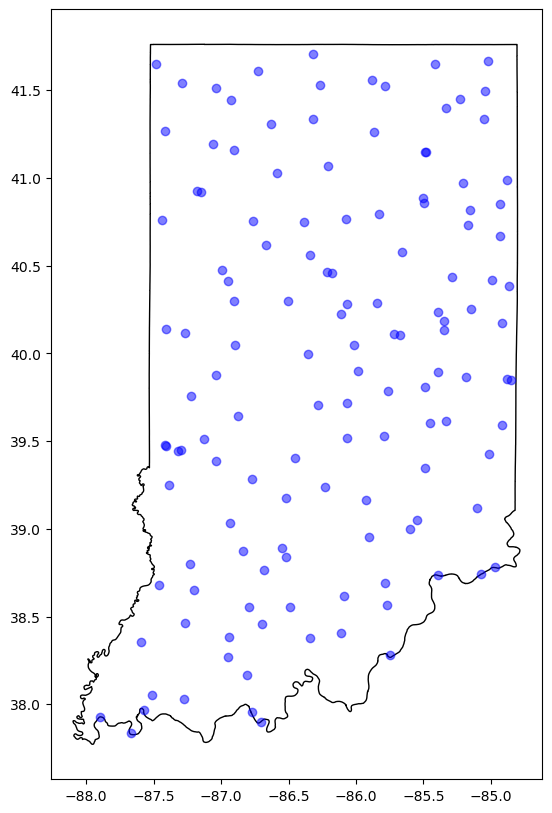

In [7]:
""" Use the IN boundary to clip the snow. """

# convert the in boundary to the same projection as the snow
IN_boundary_gdf = IN_boundary_gdf.to_crs(inv_gdf.crs)

# clip the snow to the IN boundary
IN_inv_gdf = gpd.clip(inv_50_gdf, IN_boundary_gdf) # .clip(input_geodataframe, clip_geodataframe)

# isolate this to just the SNOW variable
IN_snow_gdf = IN_inv_gdf[IN_inv_gdf.element_type == 'SNOW']

# plot the clipped snow and the state boundary
fig, ax = plt.subplots(figsize=(10, 10))
IN_boundary_gdf.plot(ax=ax, color='none', edgecolor='black')
IN_snow_gdf.plot(ax=ax, color='b', alpha=0.5)

plt.show()


In [9]:
""" Set the URL template for the GHCN-Daily data. """

# create a function to load the GHCN-Daily data for a station
def get_ghcn_daily_data(station_id):
    """ Get the GHCN-Daily data for a station. """
    # set the url template
    url_template = f"https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/{station_id}.csv"

    # load the data
    df = pd.read_csv(url_template)

    return df

# test on the first station
test_df = get_ghcn_daily_data(IN_snow_gdf.Station_ID.iloc[0])
test_df.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,MDSF,MDSF_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES
0,USC00121998,1922-01-08,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
1,USC00121998,1922-01-13,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6"
2,USC00121998,1922-01-18,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
3,USC00121998,1922-01-21,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN,NaN,NaN
4,USC00121998,1922-02-01,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN


In [11]:
""" Download data for all the stations. """
import warnings
# catch warnings
warnings.filterwarnings("error")

df_list = []
bad_station_list = []
warning_station_list = []

for station_id in tqdm(IN_snow_gdf.Station_ID):
    try:
        # check for a warning and add to the warning list if there is one
        try:
            df = get_ghcn_daily_data(station_id)
            df_list.append(df)
        except RuntimeWarning:
            print(f"Warning for station {station_id}")
            warning_station_list.append(station_pd)
    except:
        print(f"Bad station {station_id}")
        bad_station_list.append(station_id)
        continue
# reset the warning filter
warnings.resetwarnings()

  0%|          | 0/134 [00:00<?, ?it/s]

Bad station USC00128698
Bad station USC00126001
Bad station USC00122731
Bad station USC00120852
Bad station USW00093817
Bad station USC00127724
Bad station USC00124168
Bad station USC00124382
Bad station USC00124372
Bad station USC00122309
Bad station USC00126705
Bad station USC00126872
Bad station USC00128036
Bad station USC00123915
Bad station USC00127125
Bad station USC00129112
Bad station USC00122549
Bad station USC00127755
Bad station USC00129253
Bad station USC00127875
Bad station USC00129605
Bad station USC00120550
Bad station USC00125237
Bad station USC00126580
Bad station USC00121869
Bad station USC00127935
Bad station USC00126435
Bad station USC00120784
Bad station USC00122605
Bad station USC00121747
Bad station USC00122813
Bad station USC00128290
Bad station USC00126056
Bad station USC00120877
Bad station USC00123547
Bad station USC00125407
Bad station USC00123095
Bad station USC00127999
Bad station USC00127646
Bad station USC00125435
Bad station USC00123513
Bad station USC0

In [12]:
""" Combine the data into a single dataframe. """
# combine the data into a single dataframe
# concatenate the dataframes
merged_df = pd.concat(df_list + warning_station_list)

# save the data to a CSV file with today's date
merged_df.to_csv(f"ghcn_daily_{dt.datetime.today().strftime('%Y_%m_%d')}.csv")

In [ ]:
""" Convert the data to a geopandas dataframe. """

# parse the date column

# convert the data to a geopandas dataframe

In [ ]:
""" Pick a date and plot the snow """
# pick a date


# plot the snow

## Breakpoint

If you want to spend class time on your final project, here would be a good place to end the exercise.  Otherwise, I encourage you to keep going.

In [ ]:
""" Calculate the total snow each year."""
# sum by year

In [ ]:
""" Calculate the trend in snow. """

# calculate the trend in snow

# get the lat/lon for each station from the inventory

# convert the dataframe to a geodataframe

# rename the columns


In [ ]:
""" Plot the trend in snow. """


# plot the trends, using the trend magnitude as the color and marker size

# plot the state boundary


